#### Reuters Corpus

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\grees\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grees\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\grees\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Read and preprocess data

In [22]:
# Path to the C50train directory
path_to_train = 'C:/Users/grees/OneDrive/Desktop/ML_Reuters/ReutersC50/C50train'

# Initialize lists to store data
texts = [] # list of articles
authors = [] # list of authors

# Load the data
for author in os.listdir(path_to_train): # loop through all the author folders
    author_path = os.path.join(path_to_train, author) # append author name to the path
    for file_name in os.listdir(author_path): # loop through all the documents for each author
        with open(os.path.join(author_path, file_name), 'r', encoding='latin-1') as file:  # open article text file
            texts.append(file.read()) # saving article to texts list
            authors.append(author) # saving author name to authors list

# Create a DataFrame
df = pd.DataFrame({'author': authors, 'text': texts}) # create dataframe with authors and texts

# Text Preprocessing
lemmatizer = WordNetLemmatizer() #initialize #Lemmatize means root words
stop_words = set(stopwords.words('english')) #storing stop words 

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower()) # Converting words to lowercase and splitting the text to words
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words] #removing numbers and stop words from each article
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text) #calling function every text column
df.head() #Can see the original text and the processed text

,author,text,processed_text
0,AaronPressman,The Internet may be overflowing with new techn...,internet may overflowing new technology crime ...
1,AaronPressman,The U.S. Postal Service announced Wednesday a ...,postal service announced wednesday plan boost ...
2,AaronPressman,Elementary school students with access to the ...,elementary school student access internet lear...
3,AaronPressman,An influential Internet organisation has backe...,influential internet organisation backed away ...
4,AaronPressman,An influential Internet organisation has backe...,influential internet organisation backed away ...


#### Generate TF-IDF matrix for the documents


In [26]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2)) # Initialize: Using n gram taking both unigram and bigram
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text']) #apply on the processed text column
#tfidf_matrix.toarray() #This array has 1000 words collected from all articles using TF(across). The numbers stored are TDF-IDF weights.Zero mean it was not present in this article
# Convert to DataFrame for PCA and Clustering
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names())
#tfidf_df .This dataframe contains words as heading and their TF-IDF weights

#### Reduce dimensions of TF-IDF matrix with PCA 

In [28]:
n_comp = 50 # setting the max number of components
pca = PCA(n_components=n_comp)
Principal_components=pca.fit_transform(tfidf_df) #Running PCA on the dataframe from tf-idf
pca_cols = ["pc_"+ str(x+1) for x in range(n_comp)] #Naming columns as PC1,PC2...etc.
pca_df = pd.DataFrame(data = Principal_components, columns = pca_cols) #This dataframe has 50 PC

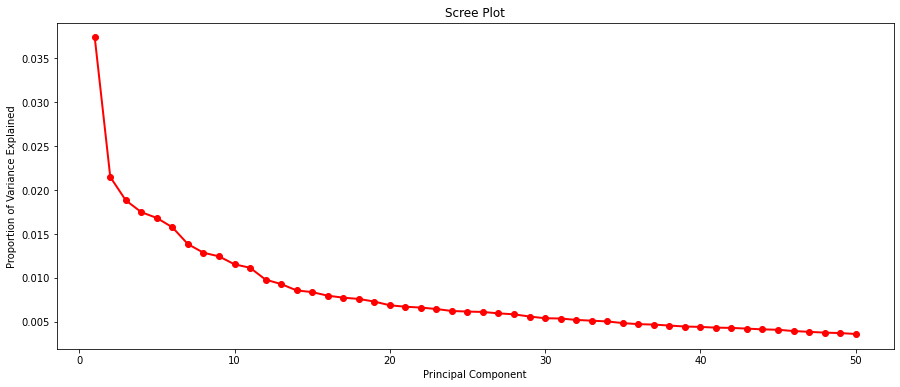

In [31]:
#Variance explained by PC
plt.figure(figsize=(15,6))
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

#### *We can choose 10 components for further analysis*

In [32]:
# Reduce dimensionality with PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(tfidf_df)
# saving first two components for plotting
df['pca_one'] = pca_result[:, 0]
df['pca_two'] = pca_result[:, 1]


#### Clustering the reduced dimension TF-IDF with K_Means

In [34]:
#function to calculate gap-statistic and return optimal clusters
def compute_gap_statistic(X, n_refs=20, max_clusters=10):
    gaps = np.zeros(max_clusters)
    std_devs = np.zeros(max_clusters)
    reference_inertia = np.zeros(max_clusters)
   
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        actual_inertia = kmeans.inertia_
       
        refs = np.zeros(n_refs)
        for i in range(n_refs):
            random_data = np.random.random_sample(size=X.shape)
            kmeans_ref = KMeans(n_clusters=k, random_state=42)
            kmeans_ref.fit(random_data)
            refs[i] = kmeans_ref.inertia_
       
        reference_inertia[k-1] = np.mean(refs)
        gaps[k-1] = np.log(reference_inertia[k-1]) - np.log(actual_inertia)
        std_devs[k-1] = np.std(np.log(refs)) * np.sqrt(1 + 1 / n_refs)
   
    optimal_k = np.argmax(gaps[:-1] - gaps[1:] + std_devs[1:]) + 1
   
    return gaps, optimal_k

gaps, k = compute_gap_statistic(pca_result)


In [36]:
gaps, k

(array([1.63856457, 1.72830735, 1.78918252, 1.863377  , 1.93607068,
        2.02257759, 2.12045465, 2.18073273, 2.29025092, 2.3693838 ]), 7)

In [37]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(pca_result)


#### Visualization

<AxesSubplot:>

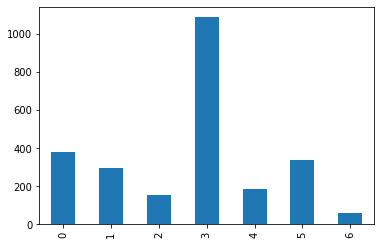

In [38]:
df['cluster'].value_counts().sort_index().plot(kind='bar') #The articles in each cluster

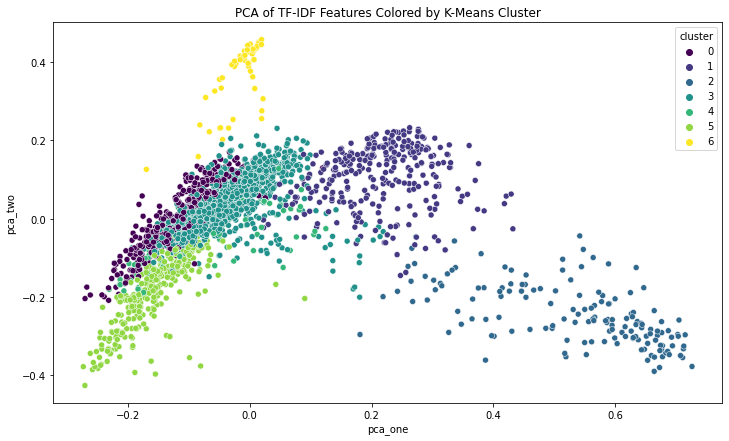

In [39]:
# Plot the clusters
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='pca_one', y='pca_two', hue='cluster', palette='viridis')
plt.title('PCA of TF-IDF Features Colored by K-Means Cluster')
plt.show()

#### Key Predictors in each cluster

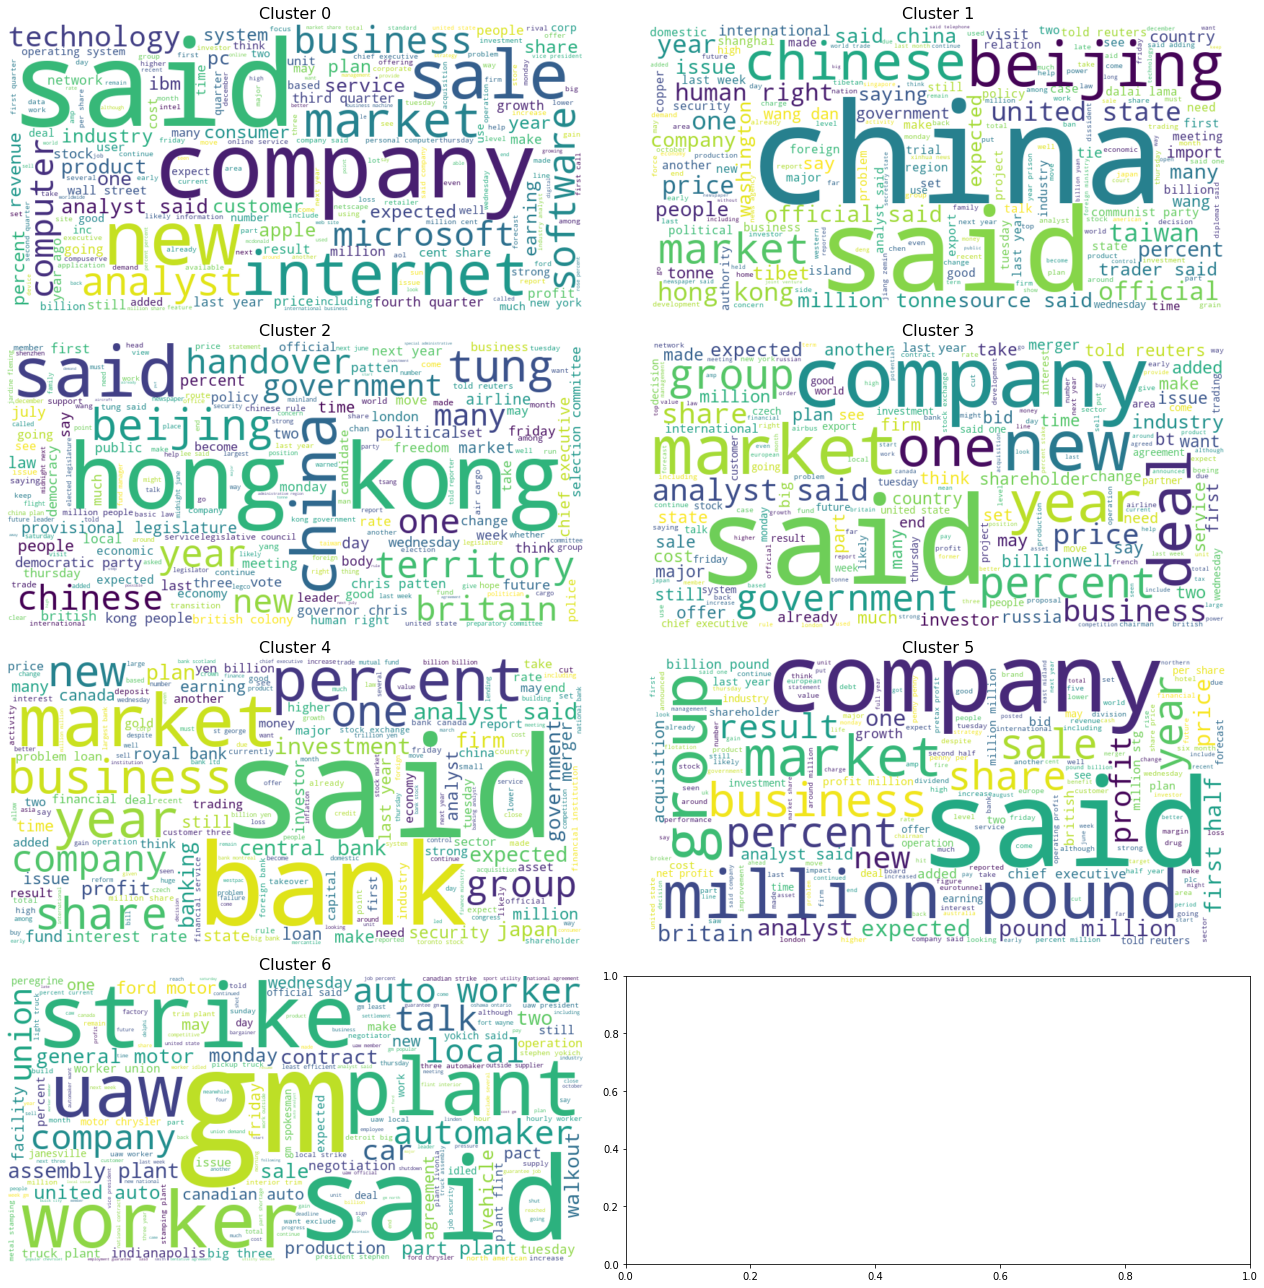

In [43]:
# WordCloud for each cluster
# Set up a 4*2 grid for the word clouds
fig, axes = plt.subplots(4, 2, figsize=(18, 18))
# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate word clouds for each cluster
for i, cluster in enumerate(range(k)):
    cluster_texts = ' '.join(df[df['cluster'] == cluster]['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_texts)
    
    # Plot the wordcloud in the grid
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Cluster {cluster}', fontsize=16)
    axes[i].axis('off')  # Hide axes for cleaner look

# Hide any empty subplots (if clusters < k)
for j in range(i + 1, k):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Identifying the best keywords that differentiate the clusters

In [45]:
# Add the cluster labels to the TF-IDF DataFrame
tfidf_df['cluster'] = df['cluster']
# Calculate the mean TF-IDF score for each word in each cluster
cluster_keywords = tfidf_df.groupby('cluster').mean().transpose()

In [46]:
# For each cluster, get the top N keywords
top_n = 20  # Number of top keywords to extract
top_keywords = {}
for cluster in cluster_keywords.columns:
    top_keywords[cluster] = cluster_keywords[cluster].nlargest(top_n).index.tolist()
    
# Display the top keywords for each cluster
for cluster, keywords in top_keywords.items():
    print(f"Cluster {cluster}: {', '.join(keywords)}")


Cluster 0: said, quarter, computer, internet, company, analyst, software, sale, microsoft, apple, share, year, new, pc, percent, earnings, technology, million, service, product
Cluster 1: china, said, beijing, chinese, wang, official, taiwan, state, tonne, tibet, year, foreign, trade, communist, party, dissident, human, human right, poultry, would
Cluster 2: kong, hong kong, hong, china, tung, said, legislature, chinese, territory, beijing, handover, cargo, committee, british, law, people, britain, rule, would, year
Cluster 3: said, company, would, percent, market, share, analyst, billion, year, new, million, czech, stock, deal, one, price, gold, industry, government, group
Cluster 4: bank, said, banking, loan, financial, analyst, billion, stock, share, market, percent, would, canada, fund, year, investment, foreign, million, rate, yen
Cluster 5: pound, million, profit, said, million pound, percent, penny, year, group, share, company, market, sale, business, analyst, half, would, stg, 

### Cluster themes
Assigning cluster themes based on top keywords

- Cluster 0: Technology and Corporate Performance

Keywords such as "computer," "internet," "software," "microsoft," "apple," "earnings," and "technology" suggest a focus on the technology industry, corporate performance, and related market dynamics.

- Cluster 1: Chinese Politics and International Relations

Keywords like "china," "beijing," "taiwan," "communist," "party," "human rights," and "trade" indicate a focus on Chinese politics, international relations, and human rights issues.

- Cluster 2: Hong Kong and Sino-British Relations

Keywords such as "hong kong," "china," "tung," "legislature," "hand over," "british," and "rule" relate to the political situation in Hong Kong, particularly around the handover from British to Chinese rule.

- Cluster 3: Global Markets and Economic Activity

Keywords like "company," "market," "percent," "share," "billion," "stock," "deal," and "industry" suggest a broad focus on global markets, economic activity, and corporate investments.

- Cluster 4: Banking and Financial Services

Keywords such as "bank," "loan," "financial," "investment," "stock," "market," and "fund" indicate a focus on banking, financial services, and investment markets.

- Cluster 5: British Economy and Corporate Profits

Keywords like "pound," "profit," "percent," "share," "company," "market," "british," and "business" suggest a focus on the British economy, corporate profits, and market performance.

- Cluster 6: Automotive Industry and Labor Relations

Keywords such as "gm," "plant," "worker," "strike," "auto," "union," "contract," and "ford" indicate a focus on the automotive industry, labor relations, and union activities.


In [47]:
# Define the mapping of cluster numbers to theme names
cluster_theme_mapping = {
    0: "Technology and Corporate Performance",
    1: "Chinese Politics and International Relations",
    2: "Hong Kong and Sino-British Relations",
    3: "Global Markets and Economic Activity",
    4: "Banking and Financial Services",
    5: "British Economy and Corporate Profits",
    6: "Automotive Industry and Labor Relations"
}

# Assuming you have a DataFrame `df` with the 'cluster' column:
# Map the theme names to the clusters in the DataFrame
df['theme'] = df['cluster'].map(cluster_theme_mapping)

# Display the DataFrame with the mapped theme names
df[['cluster', 'theme']].drop_duplicates().sort_values(by='cluster')


,cluster,theme
0,0,Technology and Corporate Performance
150,1,Chinese Politics and International Relations
553,2,Hong Kong and Sino-British Relations
2,3,Global Markets and Economic Activity
7,4,Banking and Financial Services
80,5,British Economy and Corporate Profits
351,6,Automotive Industry and Labor Relations


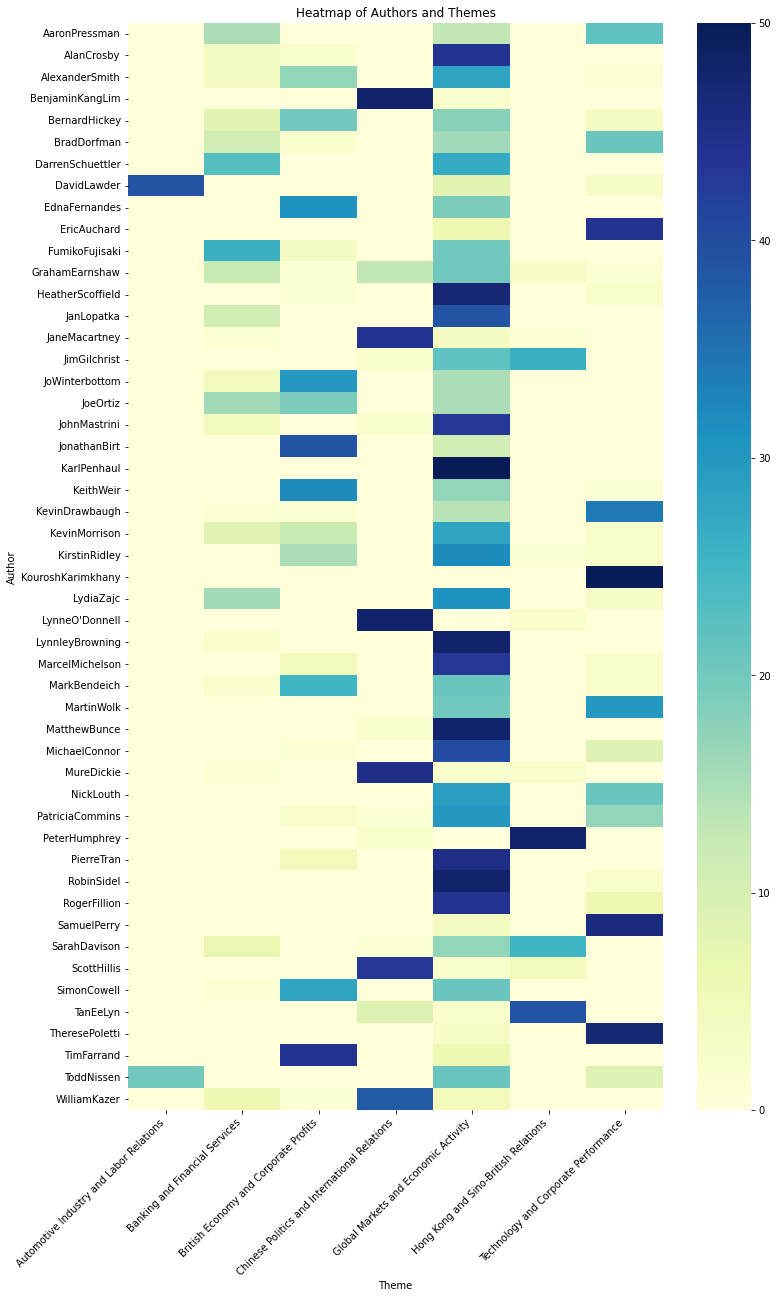

In [50]:
# Create a cross-tabulation (contingency table) of authors and themes
author_theme_crosstab = pd.crosstab(df['author'], df['theme'])

# Plot the heatmap
plt.figure(figsize=(12, 20))
sns.heatmap(author_theme_crosstab, cmap="YlGnBu", annot=False, fmt="d")
plt.title("Heatmap of Authors and Themes")
plt.xlabel("Theme")
plt.ylabel("Author")
plt.xticks(rotation=45, ha='right')
plt.show()


*Authors specialising in specific topics:*

- Benjamin Kang Lim and Lynne O'Donnell- show an exclusive focus on the "Chinese Politics and International Relations" theme with 48 articles each. This indicates that these authors specialize almost entirely in Chinese political topics.
- Kourosh Karimkhany stands out for exclusively writing in the "Technology and Corporate Performance" theme, contributing all 50 of their articles to this area.
- Peter Humphrey is another example of specialization, with all 48 of their articles focused on "Hong Kong and Sino-British Relations."

*Versatile Authors:*

- Brad Dorfman and Joe Ortiz contribute significantly across three themes. 
- Brad Dorfman writes about "Banking and Financial Services" (11), "British Economy and Corporate Profits" (2), and "Technology and Corporate Performance" (21). 
- Similarly, Joe Ortiz is active in "Banking and Financial Services" (16), "British Economy and Corporate Profits" (19), and "Global Markets and Economic Activity" (15).
- Aaron Pressman writes on "Banking and Financial Services" (15), "Global Markets and Economic Activity" (13), and "Technology and Corporate Performance" (22), showing diversity in coverage across finance and technology.

*Dominance in Global Markets and Economic Activity:*

- Karl Penhaul exclusively covers "Global Markets and Economic Activity" with 50 articles. 
- Other authors like Heather Scoffield (47) and John Mastrini (43) also have a strong presence in this theme, indicating that it is a common focus area among multiple authors.
- Alan Crosby and Jan Lopatka show a clear preference for writing on "Global Markets and Economic Activity," with 44 and 39 articles, respectively, suggesting that this theme is widely covered by journalists with a strong interest in market and economic dynamics.

*British Economy and Corporate Profits:*

- Jonathan Birt is heavily focused on the "British Economy and Corporate Profits" theme, contributing 39 articles.
- Similarly, Keith Weir (32) and Tim Farrand (44) show significant contributions, highlighting the importance of this theme among certain authors.
- Jo Winterbottom contributes a large number of articles (30) to this theme, indicating their strong interest or specialization in this area.

*Theme Clustering:*

- Automotive Industry and Labor Relations is a niche theme, with only a few authors like David Lawder (39) and Todd Nissen (20) focusing on it. This suggests a specialized interest rather than a broad focus across many authors.
- Hong Kong and Sino-British Relations has a significant focus from specific authors like Peter Humphrey (48) and Tan Ee Lyn (39), indicating that a few authors dominate this theme, possibly due to expertise or regional focus.

*General Observations:*
- The majority of authors show a strong preference for one or two themes, suggesting that while some journalists are versatile, many tend to focus on a specific niche.
- Themes like "Chinese Politics and International Relations" and "Global Markets and Economic Activity" are highly specialized, with only a few authors contributing the majority of the articles.
- There is less overlap across themes for most authors, indicating clear thematic boundaries in the types of content produced.

*Conclusion:*
The crosstab analysis reveals distinct patterns of specialization among authors, with some focusing exclusively on a single theme, while others are more versatile, contributing to multiple themes. This distribution suggests both deep expertise and diverse coverage within the dataset, which could be valuable for content strategy, targeted reporting, and understanding thematic interests within the journalist community.






